In [1]:
import re
import numpy as np
import collections
from sklearn import metrics
from sklearn.cross_validation import train_test_split
import tensorflow as tf
import pandas as pd
from unidecode import unidecode
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import time
import malaya

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
tokenizer = malaya.preprocessing._SocialTokenizer().tokenize
rules_normalizer = malaya.texts._tatabahasa.rules_normalizer

def is_number_regex(s):
    if re.match("^\d+?\.\d+?$", s) is None:
        return s.isdigit()
    return True

def detect_money(word):
    if word[:2] == 'rm' and is_number_regex(word[2:]):
        return True
    else:
        return False

def preprocessing(string):
    tokenized = tokenizer(unidecode(string))
    tokenized = [malaya.stem.naive(w) for w in tokenized]
    tokenized = [w.lower() for w in tokenized if len(w) > 1]
    tokenized = [rules_normalizer.get(w, w) for w in tokenized]
    tokenized = ['<NUM>' if is_number_regex(w) else w for w in tokenized]
    tokenized = ['<MONEY>' if detect_money(w) else w for w in tokenized]
    return tokenized

In [3]:
def build_dataset(words, n_words):
    count = [['GO', 0], ['PAD', 1], ['EOS', 2], ['UNK', 3]]
    counter = collections.Counter(words).most_common(n_words)
    count.extend(counter)
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 3)
        if index == 0:
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

def str_idx(corpus, dic, maxlen, UNK = 3):
    X = np.zeros((len(corpus), maxlen))
    for i in range(len(corpus)):
        for no, k in enumerate(corpus[i][:maxlen][::-1]):
            X[i, -1 - no] = dic.get(k, UNK)
    return X

In [4]:
preprocessing('kerajaan sebenarnya sangat bencikan rakyatnya, minyak naik dan segalanya jd')

['raja',
 'benar',
 'sangat',
 'benci',
 'rakyat',
 'minyak',
 'naik',
 'gala',
 'jadi']

In [5]:
import json

with open('tokenization.json') as fopen:
    dataset = json.load(fopen)
texts = dataset['texts']
labels = dataset['labels']
del dataset

In [6]:
with open('subjectivity-dictionary.json') as fopen:
    d = json.load(fopen)
dictionary = d['dictionary']
rev_dictionary = d['reverse_dictionary']

In [7]:
def position_encoding(inputs):
    T = tf.shape(inputs)[1]
    repr_dim = inputs.get_shape()[-1].value
    pos = tf.reshape(tf.range(0.0, tf.to_float(T), dtype=tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(inputs)[0], 1, 1])

class Model:
    def __init__(
        self,
        size_layer,
        num_layers,
        dimension_output,
        learning_rate,
        dropout,
        dict_size,
    ):
        def cells(size, reuse = False):
            return tf.contrib.rnn.DropoutWrapper(
                tf.nn.rnn_cell.LSTMCell(
                    size,
                    initializer = tf.orthogonal_initializer(),
                    reuse = reuse,
                ),
                state_keep_prob = dropout,
                output_keep_prob = dropout,
            )

        self.X = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.int32, [None])
        encoder_embeddings = tf.Variable(
            tf.random_uniform([dict_size, size_layer], -1, 1)
        )
        encoder_embedded = tf.nn.embedding_lookup(encoder_embeddings, self.X)
        encoder_embedded += position_encoding(encoder_embedded)
        attention_mechanism = tf.contrib.seq2seq.LuongAttention(
            num_units = size_layer, memory = encoder_embedded
        )
        rnn_cells = tf.contrib.seq2seq.AttentionWrapper(
            cell = tf.nn.rnn_cell.MultiRNNCell(
                [cells(size_layer) for _ in range(num_layers)]
            ),
            attention_mechanism = attention_mechanism,
            attention_layer_size = size_layer,
            alignment_history = True,
        )
        outputs, last_state = tf.nn.dynamic_rnn(
            rnn_cells, encoder_embedded, dtype = tf.float32
        )
        self.alignments = tf.transpose(
            last_state.alignment_history.stack(), [1, 2, 0]
        )
        self.logits_seq = tf.layers.dense(outputs, dimension_output)
        self.logits_seq = tf.identity(self.logits_seq, name = 'logits_seq')
        self.logits = self.logits_seq[:, -1]
        self.logits = tf.identity(self.logits, name = 'logits')
        self.cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits = self.logits, labels = self.Y
            )
        )
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(self.cost)
        correct_pred = tf.equal(
            tf.argmax(self.logits, 1, output_type = tf.int32), self.Y
        )
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        self.attention = tf.nn.softmax(
            tf.reduce_sum(self.alignments[0], 1), name = 'alphas'
        )

In [8]:
size_layer = 256
num_layers = 2
dimension_output = 2
learning_rate = 1e-4
batch_size = 32
dropout = 0.8
maxlen = 100

tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(
    size_layer,
    num_layers,
    dimension_output,
    learning_rate,
    dropout,
    len(dictionary),
)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.trainable_variables())
saver.save(sess, 'luong/model.ckpt')

'luong/model.ckpt'

In [9]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'Placeholder' in n.name
        or 'logits' in n.name
        or 'alphas' in n.name)
        and 'Adam' not in n.name
        and 'beta' not in n.name
    ]
)

In [10]:
strings.split(',')

['Placeholder',
 'Placeholder_1',
 'Variable',
 'memory_layer/kernel',
 'rnn/attention_wrapper/multi_rnn_cell/cell_0/lstm_cell/kernel',
 'rnn/attention_wrapper/multi_rnn_cell/cell_0/lstm_cell/bias',
 'rnn/attention_wrapper/multi_rnn_cell/cell_1/lstm_cell/kernel',
 'rnn/attention_wrapper/multi_rnn_cell/cell_1/lstm_cell/bias',
 'rnn/attention_wrapper/attention_layer/kernel',
 'dense/kernel',
 'dense/bias',
 'logits_seq',
 'logits',
 'alphas']

In [11]:
train_X, test_X, train_Y, test_Y = train_test_split(
    texts, labels, test_size = 0.2
)

In [12]:
from tqdm import tqdm
import time

EARLY_STOPPING, CURRENT_CHECKPOINT, CURRENT_ACC, EPOCH = 3, 0, 0, 0

while True:
    lasttime = time.time()
    if CURRENT_CHECKPOINT == EARLY_STOPPING:
        print('break epoch:%d\n' % (EPOCH))
        break

    train_acc, train_loss, test_acc, test_loss = 0, 0, 0, 0
    pbar = tqdm(
        range(0, len(train_X), batch_size), desc = 'train minibatch loop'
    )
    for i in pbar:
        batch_x = str_idx(train_X[i : min(i + batch_size, len(train_X))], dictionary, maxlen)
        batch_y = train_Y[i : min(i + batch_size, len(train_X))]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost, _ = sess.run(
            [model.accuracy, model.cost, model.optimizer],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        assert not np.isnan(cost)
        train_loss += cost
        train_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    pbar = tqdm(range(0, len(test_X), batch_size), desc = 'test minibatch loop')
    for i in pbar:
        batch_x = str_idx(test_X[i : min(i + batch_size, len(test_X))], dictionary, maxlen)
        batch_y = test_Y[i : min(i + batch_size, len(test_X))]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost = sess.run(
            [model.accuracy, model.cost],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        test_loss += cost
        test_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    train_loss /= len(train_X) / batch_size
    train_acc /= len(train_X) / batch_size
    test_loss /= len(test_X) / batch_size
    test_acc /= len(test_X) / batch_size

    if test_acc > CURRENT_ACC:
        print(
            'epoch: %d, pass acc: %f, current acc: %f'
            % (EPOCH, CURRENT_ACC, test_acc)
        )
        CURRENT_ACC = test_acc
        CURRENT_CHECKPOINT = 0
    else:
        CURRENT_CHECKPOINT += 1
        
    print('time taken:', time.time() - lasttime)
    print(
        'epoch: %d, training loss: %f, training acc: %f, valid loss: %f, valid acc: %f\n'
        % (EPOCH, train_loss, train_acc, test_loss, test_acc)
    )
    EPOCH += 1

train minibatch loop:   0%|          | 0/250 [00:00<?, ?it/s]

epoch: 0, pass acc: 0.000000, current acc: 0.654457
time taken: 54.83946204185486
epoch: 0, training loss: 0.638534, training acc: 0.613628, valid loss: 0.776525, valid acc: 0.654457



train minibatch loop:   0%|          | 0/250 [00:00<?, ?it/s]

epoch: 1, pass acc: 0.654457, current acc: 0.744104
time taken: 54.86456489562988
epoch: 1, training loss: 0.541612, training acc: 0.732212, valid loss: 0.550787, valid acc: 0.744104



train minibatch loop:   0%|          | 0/250 [00:00<?, ?it/s]

epoch: 2, pass acc: 0.744104, current acc: 0.797514
time taken: 54.93132925033569
epoch: 2, training loss: 0.469353, training acc: 0.779395, valid loss: 0.465660, valid acc: 0.797514



train minibatch loop:   0%|          | 0/250 [00:00<?, ?it/s]

epoch: 3, pass acc: 0.797514, current acc: 0.815075
time taken: 54.95585513114929
epoch: 3, training loss: 0.398628, training acc: 0.825951, valid loss: 0.428971, valid acc: 0.815075



train minibatch loop:   0%|          | 0/250 [00:00<?, ?it/s]

epoch: 4, pass acc: 0.815075, current acc: 0.816301
time taken: 54.9445219039917
epoch: 4, training loss: 0.338529, training acc: 0.856820, valid loss: 0.429633, valid acc: 0.816301



train minibatch loop:   0%|          | 0/250 [00:00<?, ?it/s]

time taken: 54.94210863113403
epoch: 5, training loss: 0.296259, training acc: 0.879282, valid loss: 0.452722, valid acc: 0.811061



train minibatch loop:   0%|          | 0/250 [00:00<?, ?it/s]

epoch: 6, pass acc: 0.816301, current acc: 0.825612
time taken: 54.880356311798096
epoch: 6, training loss: 0.254458, training acc: 0.902623, valid loss: 0.475018, valid acc: 0.825612



train minibatch loop:   0%|          | 0/250 [00:00<?, ?it/s]

time taken: 54.929993629455566
epoch: 7, training loss: 0.225643, training acc: 0.913540, valid loss: 0.476889, valid acc: 0.819814



train minibatch loop:   0%|          | 0/250 [00:00<?, ?it/s]

epoch: 8, pass acc: 0.825612, current acc: 0.836650
time taken: 54.952250957489014
epoch: 8, training loss: 0.200882, training acc: 0.926089, valid loss: 0.478837, valid acc: 0.836650



train minibatch loop:   0%|          | 0/250 [00:00<?, ?it/s]

time taken: 54.89281368255615
epoch: 9, training loss: 0.168581, training acc: 0.936127, valid loss: 0.527657, valid acc: 0.828622



train minibatch loop:   0%|          | 0/250 [00:00<?, ?it/s]

time taken: 55.14256834983826
epoch: 10, training loss: 0.155335, training acc: 0.943657, valid loss: 0.548047, valid acc: 0.826114



test minibatch loop: 100%|██████████| 63/63 [00:04<00:00, 14.66it/s, accuracy=0.889, cost=0.315]

time taken: 55.782755613327026
epoch: 11, training loss: 0.134608, training acc: 0.953947, valid loss: 0.588214, valid acc: 0.818086

break epoch:12



In [13]:
saver.save(sess, 'luong/model.ckpt')

'luong/model.ckpt'

In [14]:
text = preprocessing('kerajaan sebenarnya sangat bencikan rakyatnya, minyak naik dan segalanya')
new_vector = str_idx([text], dictionary, len(text))
sess.run(tf.nn.softmax(model.logits), feed_dict={model.X:new_vector})

array([[2.4688494e-04, 9.9975306e-01]], dtype=float32)

In [15]:
real_Y, predict_Y = [], []

pbar = tqdm(
    range(0, len(test_X), batch_size), desc = 'validation minibatch loop'
)
for i in pbar:
    batch_x = str_idx(test_X[i : min(i + batch_size, len(test_X))], dictionary, maxlen)
    batch_y = test_Y[i : min(i + batch_size, len(test_X))]
    predict_Y += np.argmax(
        sess.run(
            model.logits, feed_dict = {model.X: batch_x, model.Y: batch_y}
        ),
        1,
    ).tolist()
    real_Y += batch_y

validation minibatch loop: 100%|██████████| 63/63 [00:04<00:00, 14.41it/s]


In [16]:
print(
    metrics.classification_report(
        real_Y, predict_Y, target_names = ['negative', 'positive']
    )
)

             precision    recall  f1-score   support

   negative       0.79      0.84      0.82       998
   positive       0.83      0.78      0.80       995

avg / total       0.81      0.81      0.81      1993



In [17]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [18]:
freeze_graph('luong', strings)

INFO:tensorflow:Restoring parameters from luong/model.ckpt
INFO:tensorflow:Froze 9 variables.
INFO:tensorflow:Converted 9 variables to const ops.
457 ops in the final graph.


In [19]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
    return graph

In [20]:
g = load_graph('luong/frozen_model.pb')
x = g.get_tensor_by_name('import/Placeholder:0')
logits_seq = g.get_tensor_by_name('import/logits_seq:0')
logits = g.get_tensor_by_name('import/logits:0')
alphas = g.get_tensor_by_name('import/alphas:0')
test_sess = tf.InteractiveSession(graph = g)
result = test_sess.run([logits, alphas, logits_seq], feed_dict = {x: new_vector})

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [22]:
news_string = 'Kerajaan juga perlu prihatin dan peka terhadap nasib para nelayan yang bergantung rezeki sepenuhnya kepada sumber hasil laut. Malah, projek ini memberikan kesan buruk yang berpanjangan kepada alam sekitar selain menjejaskan mata pencarian para nelayan'

In [23]:
text = preprocessing(news_string)
new_vector = str_idx([text], dictionary, len(text))
result = test_sess.run([tf.nn.softmax(logits), alphas, tf.nn.softmax(logits_seq)], feed_dict = {x: new_vector})

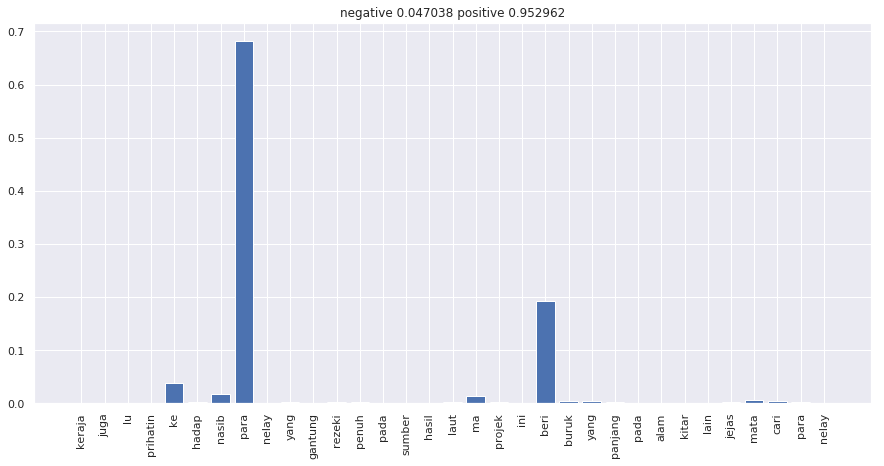

In [24]:
plt.figure(figsize = (15, 7))
labels = [word for word in text]
val = [val for val in result[1]]
plt.bar(np.arange(len(labels)), val)
plt.xticks(np.arange(len(labels)), labels, rotation = 'vertical')
plt.title('negative %f positive %f' % (result[0][0,0], result[0][0,1]))
plt.show()

In [25]:
result[2]

array([[[3.9151531e-02, 9.6084851e-01],
        [2.3458233e-02, 9.7654176e-01],
        [1.1432072e-02, 9.8856795e-01],
        [4.2996742e-03, 9.9570036e-01],
        [1.3745558e-03, 9.9862552e-01],
        [1.4014016e-03, 9.9859864e-01],
        [1.0488124e-03, 9.9895120e-01],
        [1.9265183e-03, 9.9807346e-01],
        [3.3360033e-03, 9.9666399e-01],
        [8.0528753e-03, 9.9194711e-01],
        [6.6224528e-03, 9.9337751e-01],
        [4.0540318e-03, 9.9594599e-01],
        [7.7450857e-04, 9.9922550e-01],
        [3.2972530e-03, 9.9670273e-01],
        [3.1471432e-03, 9.9685293e-01],
        [5.1080845e-03, 9.9489188e-01],
        [2.1771374e-03, 9.9782288e-01],
        [9.9299010e-03, 9.9007016e-01],
        [6.1049298e-03, 9.9389511e-01],
        [1.5008459e-02, 9.8499161e-01],
        [7.1228417e-03, 9.9287719e-01],
        [2.7062252e-02, 9.7293776e-01],
        [1.0936188e-02, 9.8906380e-01],
        [8.8909073e-03, 9.9110913e-01],
        [1.6887451e-02, 9.8311251e-01],
